In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy.stats import circstd,circmean
from scipy.ndimage.filters import gaussian_filter
from collections import *
from matplotlib.pyplot import *

In [2]:
path_to_files='./param_space_pop_data_files/'
tau_b=np.load(path_to_files+'tau_b.npy')
sigma_k=np.load(path_to_files+'sigma_k.npy')
gamma=np.load(path_to_files+'gamma.npy')
k=np.load(path_to_files+'k.npy')
m=np.load(path_to_files+'m.npy')

dict_param=OrderedDict([('tau_b',tau_b),('sigma_k',sigma_k),('gamma',gamma),('k',k),('m',m)])
latex_param_names=OrderedDict([('tau_b',r'$\tau_{b}$'),('sigma_k',r'$\sigma_{k}$'),('gamma',r'$\gamma$'),('k',r'$k$'),('m',r'$m$')])

In [3]:
def best_sols(filename_max_err,filename_nan,dict_param,max_error_thresh=30):
    max_err_arr=np.squeeze(np.load(path_to_files+filename_max_err))
    num_fm=5
    num_param=len(dict_param)
    b_sols=np.argwhere(max_err_arr<=max_error_thresh)
    b_values=np.zeros((b_sols.shape[0],num_param))
    for k in xrange(num_param):
        b_values[:,k]=dict_param[dict_param.keys()[k]][b_sols[:,k]]
    return b_values,b_sols 

In [4]:
def hist_production(filename_max_err,filename_nan):
    color='#ff7f0e'
    gs=GridSpec(27,20)
    gs.update(wspace=1.5,hspace=1.5)
    ftsize=14
    max_err_arr=np.load(path_to_files+filename_max_err)
    max_err_flat=np.reshape(max_err_arr,(max_err_arr.size))    
    max_err_masked= max_err_flat[np.logical_not(np.isnan(max_err_flat))]
    nan_counter=np.load(path_to_files+filename_nan)
    m_car=np.mean(max_err_masked)
    sd_car=np.std(max_err_masked)
    
    subplot(gs[6:11,15:20])
    y,_,_=hist(max_err_masked,weights=100.0/(max_err_masked.size)*np.ones((max_err_masked.size)),edgecolor=None,lw=0,bins=20,color=color,alpha=0.7)
    plot([m_car,m_car],[0,max(y)],ls='--',lw=2,label='Mean',alpha=0.7)
    ylabel('% of the data',fontsize=ftsize)
    xlabel('Max error (deg)',fontsize=ftsize)
    xticks(fontsize=ftsize)
    yticks(fontsize=ftsize)
    legend(bbox_to_anchor=[1.1,1.025])   


In [5]:
def phase_cuve_plots(filename_phase,filename_sd,filename_max_err,filename_nan):
    gs=GridSpec(27,20)
    gs.update(wspace=1.5, hspace=1.5)
    ftsize=14
    color='#ff7f0e'
    phase=np.load(path_to_files+filename_phase)
    sd=np.load(path_to_files+filename_sd)

    b_values,b_sols=best_sols(filename_max_err,filename_nan,dict_param,360)
    b_values_best,b_sols_best=best_sols(filename_max_err,filename_nan,dict_param,np.nanmin(np.load(path_to_files+filename_max_err)))

    fm=[4,8,16,32,64]
    exp_data=[37, 40, 62, 83, 115]
    std_exp_data=[46, 29, 29, 31,37]
    subplot(gs[0:5,15:20])
    for i in xrange(b_sols.shape[0]):
        indices=(slice(None),int(b_sols[i,0]),int(b_sols[i,1]),int(b_sols[i,2]),int(b_sols[i,3]),int(b_sols[i,4]))
        if i==0:           
            plot(fm,phase[indices],lw=0.5,alpha=0.2,label='Model (all)',color=color)

        else:
            plot(fm,phase[indices],lw=0.5,alpha=0.2,color=color)

    indices_best=(slice(None),int(b_sols_best[0,0]),int(b_sols_best[0,1]),int(b_sols_best[0,2]),int(b_sols_best[0,3]),int(b_sols_best[0,4]))
    errorbar(fm, exp_data,std_exp_data,lw=2.5, fmt='--r', label='Data')
    errorbar(fm,phase[indices_best],yerr=sd[indices_best],lw=2.5,marker='o',label='Model (best)',color="k")
    xlabel('Modulation frequency (Hz)',fontsize=ftsize)
    ylabel('Extracted IPD (deg)',fontsize=ftsize)
    xticks([4,8,16,32,64],fontsize=ftsize)
    yticks([0,90,180,270,360],fontsize=ftsize)
    ylim([0,360])
    xlim([4,64])
    grid(True)
    legend()

In [6]:
def param_hist(filename_max_err,filename_nan,dict_param,latex_param_names,max_thresh=30):
    gs=GridSpec(27,20)
    gs.update(wspace=1.5, hspace=1.5)
    nan_counter=np.load(path_to_files+filename_nan)
    max_thresh=30
    b_values,b_sols=best_sols(filename_max_err,filename_nan,dict_param,max_thresh)
    mid_param=[0.25,0.05,0.005,0,0.05]
    initial_val=[0.125,0.05,0,0,0]
    num_param=5
    color='#ff7f0e'
    for h in range(num_param):
        if h==3:
            unique, counts = np.unique(b_values[:,h], return_counts=True)    
            subplot(gs[23:27,4*h:4*(h+1)])
            title(latex_param_names[latex_param_names.keys()[h]],fontsize=20)
            bar([1.6,3.6,7.6],[counts[0],counts[1],counts[2]],lw=0,alpha=0.5,color=color)
            plot([np.mean(b_values[:,h]),np.mean(b_values[:,h])],[0,max(counts)],ls='--',lw=4,label='Mean',alpha=1)
            xticks(dict_param[dict_param.keys()[h]],fontsize=8)
            yticks([],[])
        else:   
            subplot(gs[23:27,4*h:4*(h+1)])
            title(latex_param_names[latex_param_names.keys()[h]],fontsize=20)     
            y, x, _=hist(b_values[:,h],bins=np.insert(dict_param[dict_param.keys()[h]]+mid_param[h],0,initial_val[h]),alpha=0.5,lw=0,color=color)
            plot([np.mean(b_values[:,h]),np.mean(b_values[:,h])],[0,max(y)],ls='--',lw=4,label='Mean',alpha=1)
            xticks(dict_param[dict_param.keys()[h]][::2],fontsize=8)
            yticks([],[])


In [7]:
def bfits_plots(filename_max_err,dict_param):
    
    gs=GridSpec(27,20)
    gs.update(wspace=1.5, hspace=1.5)
    max_err=np.squeeze(np.load(path_to_files+filename_max_err))
    y_axis=[2,3,1,4]
    x_axis=[0,2,3,1]
  
    ax=[]
    ftsize=14
    for i in xrange(4):
        for j in xrange(i+1):
            b_fit=np.zeros((dict_param[dict_param.keys()[y_axis[i]]].shape[0],dict_param[dict_param.keys()[x_axis[j]]].shape[0]))
            for k in xrange(dict_param[dict_param.keys()[y_axis[i]]].shape[0]):
                for l in xrange(dict_param[dict_param.keys()[x_axis[j]]].shape[0]):
                    indices=[slice(None),slice(None),slice(None),slice(None),slice(None)]
                    indices[y_axis[i]]=k
                    indices[x_axis[j]]=l
                    b_fit[k,l]=np.nanmin(max_err[tuple(indices)])
            ax.append(subplot(gs[5*i:5*(i+1),5*j:5*(j+1)]))
            x_extent_min=dict_param[dict_param.keys()[x_axis[j]]][0]
            x_extent_max=dict_param[dict_param.keys()[x_axis[j]]][-1]
            y_extent_min=dict_param[dict_param.keys()[y_axis[i]]][0]
            y_extent_max=dict_param[dict_param.keys()[y_axis[i]]][-1]                                              
            error_blur = gaussian_filter(b_fit, 1, mode='nearest')
            cs = contour(error_blur, origin='lower', aspect='auto',levels=[15, 30, 45],linewidths=2.5, colors='w',extent=[x_extent_min,x_extent_max,y_extent_min,y_extent_max])
            for level, linecol in zip(cs.levels, cs.collections):
                if level==15:
                    linecol.set_linestyle('solid')
                if level==30:
                    linecol.set_linestyle('dashed')
                if level==45:
                    linecol.set_linestyle('dotted')
    
            clabel(cs, colors='w', inline=True,fmt='%d')
            im=imshow(b_fit,origin='lower left',interpolation='nearest', aspect='auto',cmap='viridis',vmin=0,vmax=180,extent=[x_extent_min,x_extent_max,y_extent_min,y_extent_max])
            #if i==0 and j==0:
            #    text(0,0.18,'A',fontsize=28) 
            if 5*j==0:
                ylabel(latex_param_names.values()[y_axis[i]],fontsize=ftsize)
                yticks([y_extent_min,y_extent_max],fontsize=ftsize)
            else:
                yticks([])
            if 5*(i+1)==20:
                xlabel(latex_param_names.values()[x_axis[j]],fontsize=ftsize)
                xticks([x_extent_min,x_extent_max],fontsize=ftsize)
            else:
                xticks([])
    return im
   
    

In [8]:
def figure_param_space_pop(filename_phase,filename_sd,filename_max_err,filename_nan,dict_param):
    
    fig=figure(figsize=(15,18))
  
    im=bfits_plots(filename_max_err,dict_param)
    cbar_ax = fig.add_axes([0.125, 0.27, 0.775, 0.02])
    colorbar(im, cbar_ax,orientation='horizontal')
    
    ###################################################################################

    param_hist(filename_max_err,filename_nan,dict_param,latex_param_names,max_thresh=30)
    
    ####################################################################################
    
    phase_cuve_plots(filename_phase,filename_sd,filename_max_err,filename_nan)
    
    ####################################################################################
    hist_production(filename_max_err,filename_nan)
    
    fig.savefig('fig_param_space_m.pdf',bbox_inches="tight")

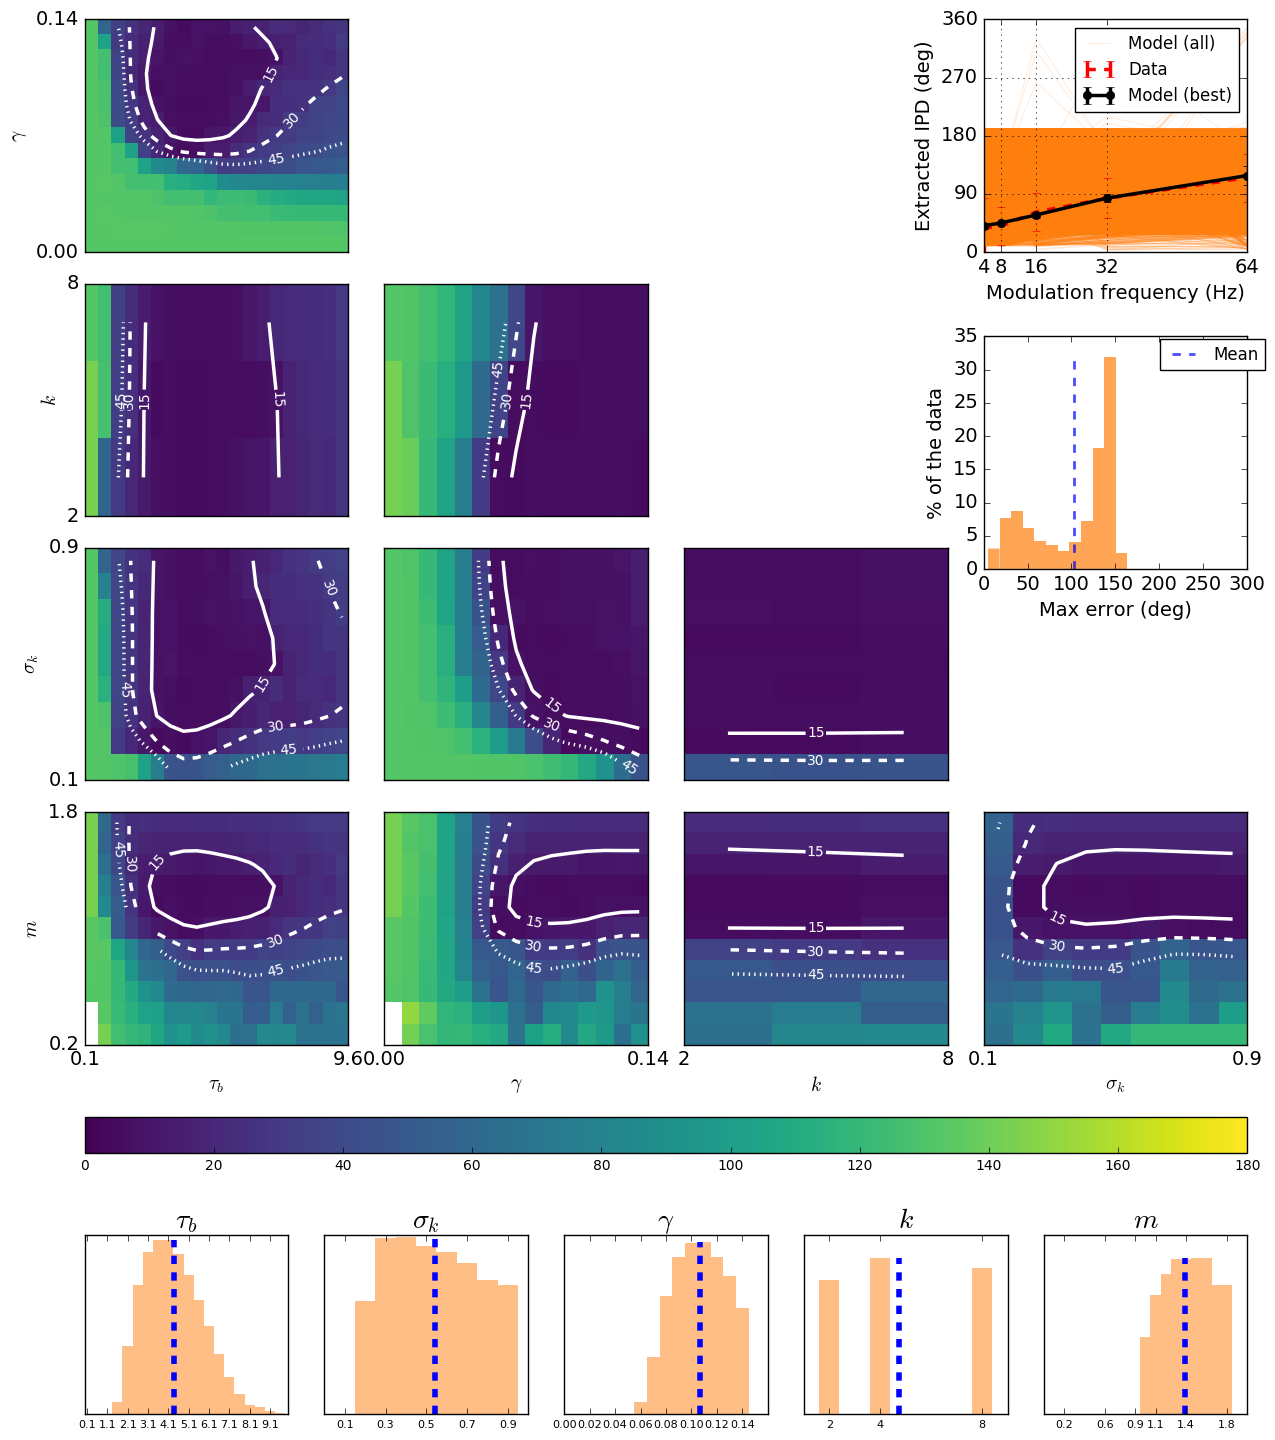

In [9]:
figure_param_space_pop('phase_500.npy','sd_500.npy','max_error_500.npy','nan_counter_500.npy',dict_param)